<a href="https://colab.research.google.com/github/mcmejiag14/Deep-Learning/blob/main/PredictingHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.7 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=b6db257f7896929aa927dfd6ef9b6fb85770a41212ea7fb54252cb4d46904131
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstal

In [2]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [4]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [5]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [6]:
print(data.raw_train.iloc[:5, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
4   5          60       RL         84.0       WD        Normal     250000


In [7]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [8]:
data.preprocess()
data.train.shape

(1460, 332)

In [9]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [10]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [11]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.06777965314686299


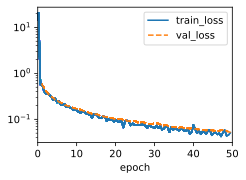

In [12]:
trainer = d2l.Trainer(max_epochs=50)
models = k_fold(trainer, data, k=5, lr=0.01)

one hider layer with 20 neuron saverage validation log mse = 0.12046444401144982


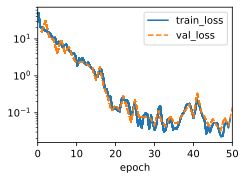

In [13]:
class MLP(d2l.LinearRegression):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
def k_fold(trainer, data, k, num_outputs, num_hiddens,lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model=MLP(num_outputs, num_hiddens, lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'one hider layer with 20 neuron saverage validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

trainer = d2l.Trainer(max_epochs=50)
models = k_fold(trainer, data, k=5,num_outputs=1, num_hiddens=20, lr=0.01)

one hider layer with 20 neuron saverage validation log mse = 0.026027035452425483


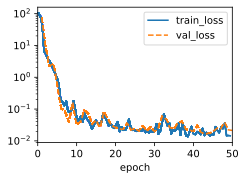

In [14]:
class MLP(d2l.LinearRegression):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
def k_fold(trainer, data, k, num_outputs, num_hiddens,lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model=MLP(num_outputs, num_hiddens, lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'one hider layer with 20 neuron saverage validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

trainer = d2l.Trainer(max_epochs=50)
models = k_fold(trainer, data, k=5,num_outputs=1, num_hiddens=20, lr=0.01)

one hider layer with 20 neuron saverage validation log mse = 0.04595078434795141


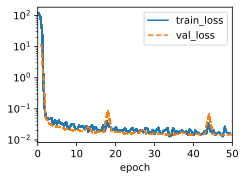

In [15]:
class MLP(d2l.LinearRegression):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
def k_fold(trainer, data, k, num_outputs, num_hiddens,lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model=MLP(num_outputs, num_hiddens, lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'one hider layer with 20 neuron saverage validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

trainer = d2l.Trainer(max_epochs=50)
models = k_fold(trainer, data, k=5,num_outputs=1, num_hiddens=20, lr=0.01)

one hider layer with 20 neuron saverage validation log mse = 0.022384103797376157


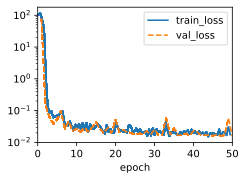

In [16]:
class MLP(d2l.LinearRegression):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
def k_fold(trainer, data, k, num_outputs, num_hiddens,lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model=MLP(num_outputs, num_hiddens, lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'one hider layer with 20 neuron saverage validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

trainer = d2l.Trainer(max_epochs=50)
models = k_fold(trainer, data, k=5,num_outputs=1, num_hiddens=20, lr=0.01)